In [1]:
import pandas as pd
import numpy as np
from numpy import array
import math
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
%matplotlib inline

In [3]:
df = pd.read_csv('Apple.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10307 entries, 0 to 10306
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       10307 non-null  object 
 1   Open       10307 non-null  float64
 2   High       10307 non-null  float64
 3   Low        10307 non-null  float64
 4   Close      10307 non-null  float64
 5   Adj Close  10307 non-null  float64
 6   Volume     10307 non-null  int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 563.8+ KB


In [4]:
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,1980-12-12,0.128348,0.128906,0.128348,0.128348,0.100600,469033600
1,1980-12-15,0.122210,0.122210,0.121652,0.121652,0.095352,175884800
2,1980-12-16,0.113281,0.113281,0.112723,0.112723,0.088353,105728000
3,1980-12-17,0.115513,0.116071,0.115513,0.115513,0.090540,86441600
4,1980-12-18,0.118862,0.119420,0.118862,0.118862,0.093165,73449600


In [5]:
df.describe()

,Open,High,Low,Close,Adj Close,Volume
count,10307.000000,10307.000000,10307.000000,10307.000000,10307.000000,1.030700e+04
mean,12.461243,12.592625,12.327482,12.464933,11.876331,3.345102e+08
std,26.250717,26.531857,25.962696,26.259096,25.976508,3.401829e+08
min,0.049665,0.049665,0.049107,0.049107,0.038490,0.000000e+00
25%,0.277902,0.285714,0.271697,0.278147,0.233399,1.266686e+08
50%,0.459821,0.467321,0.450893,0.459821,0.380151,2.227232e+08
75%,13.238571,13.415893,13.030714,13.343214,11.456702,4.162746e+08
max,156.979996,157.259995,154.389999,156.690002,156.690002,7.421641e+09


In [6]:
df.isnull().sum()

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

In [7]:
# check for duplicate rows
df.duplicated().sum()

# drop duplicate rows
df.drop_duplicates(inplace=True)

In [8]:
df.dtypes

Date          object
Open         float64
High         float64
Low          float64
Close        float64
Adj Close    float64
Volume         int64
dtype: object

In [9]:
df['Date'] = pd.to_datetime(df['Date'])

In [10]:
def add_features(data):
    # Add day of the week feature
    data['day_of_week'] = data['Date'].dt.dayofweek

    # Add month feature
    data['month'] = data['Date'].dt.month

    # Add quarter feature
    data['quarter'] = data['Date'].dt.quarter

    # Add year feature
    data['year'] = data['Date'].dt.year

    # Add week of the year feature
    data['week_of_year'] = data['Date'].dt.isocalendar().week

    # Add day of the year feature
    data['day_of_year'] = data['Date'].dt.dayofyear

    # Add lagged features
    data['lag_1'] = data['Close'].shift(1)
    data['lag_2'] = data['Close'].shift(2)
    data['lag_3'] = data['Close'].shift(3)
    data['lag_4'] = data['Close'].shift(4)
    data['lag_5'] = data['Close'].shift(5)

    return data

In [11]:
df = add_features(df)
df.dropna(inplace=True)
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume,day_of_week,month,quarter,year,week_of_year,day_of_year,lag_1,lag_2,lag_3,lag_4,lag_5
5,1980-12-19,0.126116,0.126674,0.126116,0.126116,0.098851,48630400,4,12,4,1980,51,354,0.118862,0.115513,0.112723,0.121652,0.128348
6,1980-12-22,0.132254,0.132813,0.132254,0.132254,0.103662,37363200,0,12,4,1980,52,357,0.126116,0.118862,0.115513,0.112723,0.121652
7,1980-12-23,0.137835,0.138393,0.137835,0.137835,0.108036,46950400,1,12,4,1980,52,358,0.132254,0.126116,0.118862,0.115513,0.112723
8,1980-12-24,0.145089,0.145647,0.145089,0.145089,0.113722,48003200,2,12,4,1980,52,359,0.137835,0.132254,0.126116,0.118862,0.115513
9,1980-12-26,0.158482,0.159040,0.158482,0.158482,0.124219,55574400,4,12,4,1980,52,361,0.145089,0.137835,0.132254,0.126116,0.118862


<Figure size 1000x600 with 0 Axes>

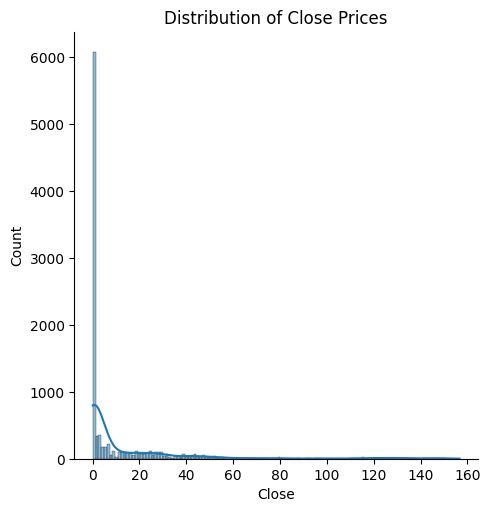

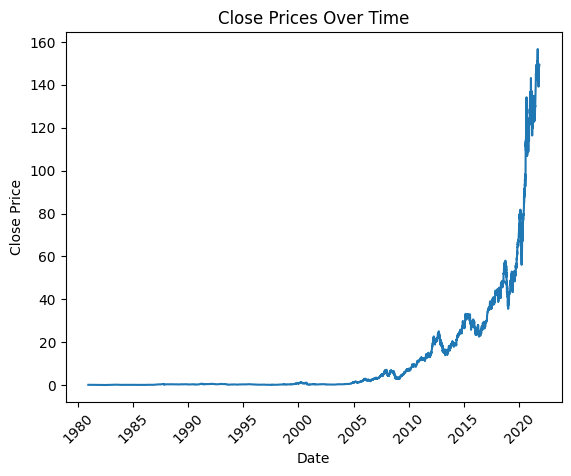

<ipython-input-12-3387356a5790>:18: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = df.corr()


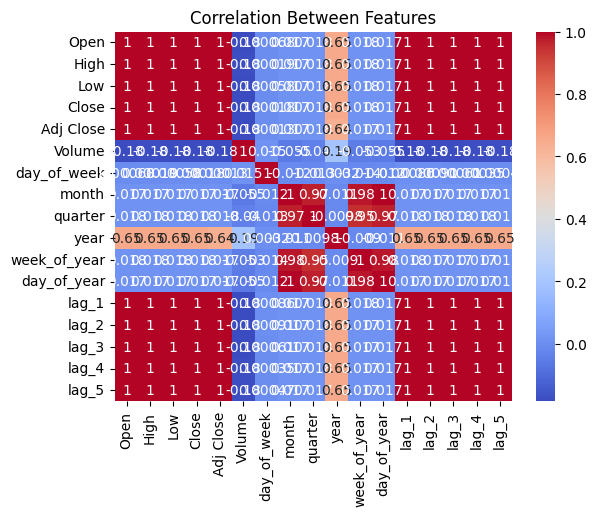

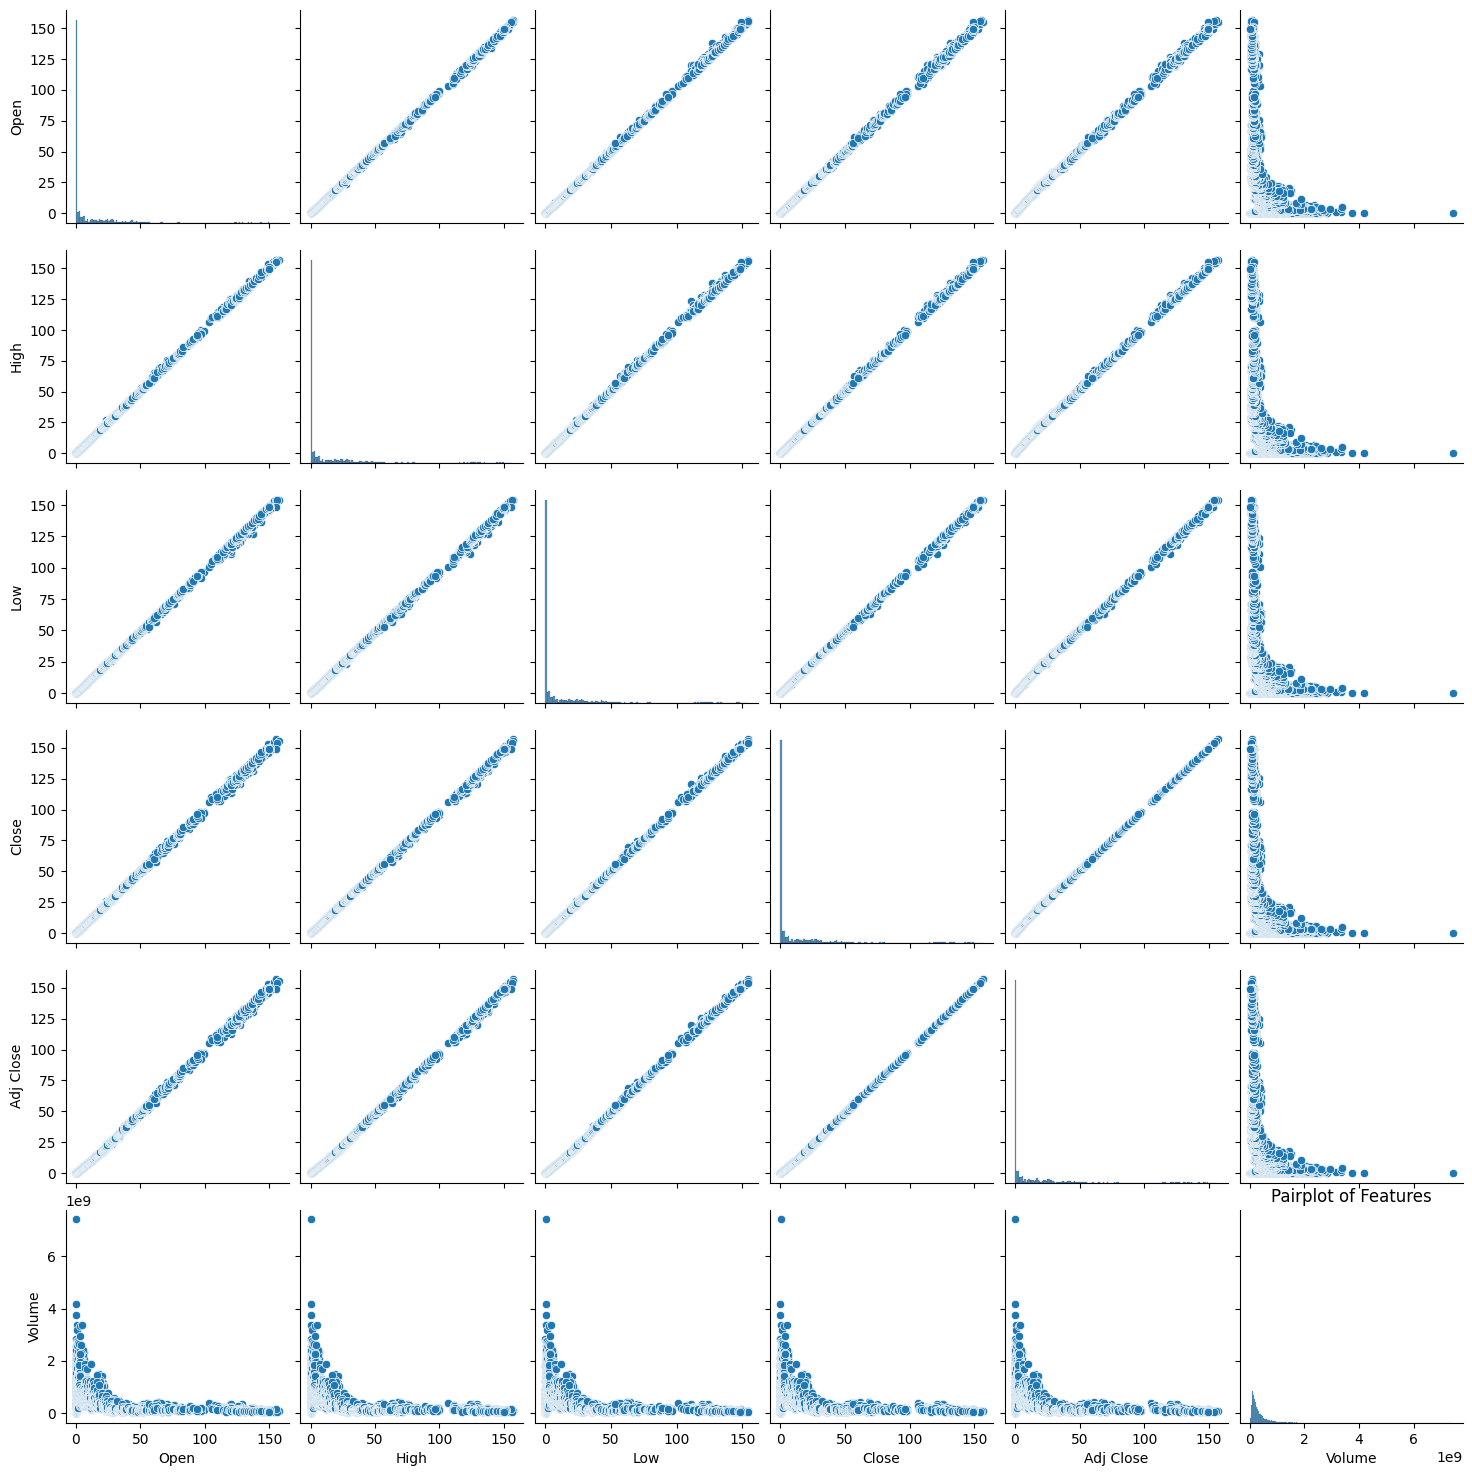

In [12]:
import seaborn as sns
plt.figure(figsize=(10, 6))

# Distribution of the target variable
sns.displot(data=df, x='Close', kde=True)
plt.title('Distribution of Close Prices')
plt.show()

# Line plot of close prices over time
sns.lineplot(data=df, x='Date', y='Close')
plt.title('Close Prices Over Time')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.xticks(rotation=45)
plt.show()

# Heatmap of correlation between features
corr = df.corr()
sns.heatmap(corr, cmap='coolwarm', annot=True)
plt.title('Correlation Between Features')
plt.show()

# Pairplot of features

sns.pairplot(data=df, vars=['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'])
plt.title('Pairplot of Features')
plt.show()

In [14]:
corr = df.corr()

<ipython-input-14-45893e33df67>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = df.corr()


In [19]:
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
import numpy
X_train, X_test, y_train, y_test = train_test_split(df[['Open', 'High', 'Low', 'Volume']], df['Close'], test_size=0.2, random_state=42)

# Baseline model
y_pred_baseline = np.full((len(y_test),), y_train.mean())
mse_baseline = mean_squared_error(y_test, y_pred_baseline)
rmse_baseline = np.sqrt(mse_baseline)
mae_baseline = mean_absolute_error(y_test, y_pred_baseline)
mape_baseline = np.mean(np.abs((y_test - y_pred_baseline) / y_test)) * 100
r2_baseline = r2_score(y_test, y_pred_baseline)

print('Baseline Model:')
print(f'MSE: {mse_baseline:.2f}')
print(f'RMSE: {rmse_baseline:.2f}')
print(f'MAE: {mae_baseline:.2f}')
print(f'MAPE: {mape_baseline:.2f}%')
print(f'R2 Score: {r2_baseline:.2f}\n')

Baseline Model:
MSE: 699.39
RMSE: 26.45
MAE: 16.53
MAPE: 3514.81%
R2 Score: -0.00



In [21]:
from sklearn.linear_model import LinearRegression
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)
y_pred_lr = lr_model.predict(X_test)
mse_lr = mean_squared_error(y_test, y_pred_lr)
rmse_lr = np.sqrt(mse_lr)
mae_lr = mean_absolute_error(y_test, y_pred_lr)
mape_lr = np.mean(np.abs((y_test - y_pred_lr) / y_test)) * 100
r2_lr = r2_score(y_test, y_pred_lr)

print('Linear Regression Model:')
print(f'MSE: {mse_lr:.2f}')
print(f'RMSE: {rmse_lr:.2f}')
print(f'MAE: {mae_lr:.2f}')
print(f'MAPE: {mape_lr:.2f}%')
print(f'R2 Score: {r2_lr:.2f}\n')

Linear Regression Model:
MSE: 0.05
RMSE: 0.22
MAE: 0.06
MAPE: 0.74%
R2 Score: 1.00



In [25]:
# Support Vector Regression Model
from sklearn import svm
from sklearn.svm import SVR
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

svr_model = SVR(kernel='linear')
svr_model.fit(X_train_scaled, y_train)
y_pred_svr = svr_model.predict(X_test_scaled)
mse_svr = mean_squared_error(y_test, y_pred_svr)
rmse_svr = np.sqrt(mse_svr)
mae_svr = mean_absolute_error(y_test, y_pred_svr)
mape_svr = np.mean(np.abs((y_test - y_pred_svr) / y_test)) * 100
r2_svr = r2_score(y_test, y_pred_svr)

print('Support Vector Regression Model:')
print(f'MSE: {mse_svr:.2f}')
print(f'RMSE: {rmse_svr:.2f}')
print(f'MAE: {mae_svr:.2f}')
print(f'MAPE: {mape_svr:.2f}%')
print(f'R2 Score: {r2_svr:.2f}\n')

Support Vector Regression Model:
MSE: 0.11
RMSE: 0.33
MAE: 0.14
MAPE: 21.58%
R2 Score: 1.00



In [29]:
from sklearn.ensemble import RandomForestRegressor
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)
mse_rf = mean_squared_error(y_test, y_pred_rf)
rmse_rf = np.sqrt(mse_rf)
mae_rf = mean_absolute_error(y_test, y_pred_rf)
mape_rf = np.mean(np.abs((y_test - y_pred_rf) / y_test)) * 100
r2_rf = r2_score(y_test, y_pred_rf)

print('Random Forest Regression Model:')
print(f'MSE: {mse_rf:.2f}')
print(f'RMSE: {rmse_rf:.2f}')
print(f'MAE: {mae_rf:.2f}')
print(f'MAPE: {mape_rf:.2f}%')
print(f'R2 Score: {r2_rf:.2f}\n')

Random Forest Regression Model:
MSE: 0.11
RMSE: 0.33
MAE: 0.09
MAPE: 0.88%
R2 Score: 1.00



In [30]:
from keras.layers import Dropout

In [31]:
data = df.filter(['Close'])
# Convert the dataframe to a numpy array
dataset = data.values
# Get the number of rows to train the model on
len_train_data = int(np.ceil( len(dataset) * .95 ))

len_train_data

9787

In [32]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0,1))
trained_scaled_data = scaler.fit_transform(dataset)

trained_scaled_data

array([[4.91627681e-04],
       [5.30812851e-04],
       [5.66442116e-04],
       ...,
       [9.48608548e-01],
       [9.52949739e-01],
       [9.52949739e-01]])

In [33]:
train_data = trained_scaled_data[0:int(len_train_data), :]
# Split the data into x_train and y_train data sets
x_train = []
y_train = []

for i in range(60, len(train_data)):
    x_train.append(train_data[i-60:i, 0])
    y_train.append(train_data[i, 0])
    if i<= 61:
        print(x_train)
        print(y_train)
        print()

# Convert the x_train and y_train to numpy arrays
x_train, y_train = np.array(x_train), np.array(y_train)

# Reshape the data
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

[array([0.00049163, 0.00053081, 0.00056644, 0.00061275, 0.00069825,
       0.0007125 , 0.00068757, 0.00065907, 0.00066975, 0.00064838,
       0.00060563, 0.00056644, 0.00054863, 0.00059494, 0.00058782,
       0.00055576, 0.00055932, 0.00057713, 0.00057   , 0.00062344,
       0.00059494, 0.00061275, 0.00062344, 0.00061988, 0.00060563,
       0.0005985 , 0.00057   , 0.00053794, 0.00049163, 0.00044532,
       0.00047382, 0.00050231, 0.00050231, 0.00050588, 0.00046313,
       0.00046313, 0.00043819, 0.00043106, 0.00041325, 0.00043106,
       0.00046313, 0.00041681, 0.00037763, 0.00038831, 0.00036338,
       0.00040613, 0.00041681, 0.00044176, 0.00044532, 0.00043463,
       0.0004275 , 0.00042394, 0.00041681, 0.00035982, 0.00032775,
       0.00030281, 0.00032775, 0.00032063, 0.00034557, 0.00037763])]
[0.00042037553475419043]

[array([0.00049163, 0.00053081, 0.00056644, 0.00061275, 0.00069825,
       0.0007125 , 0.00068757, 0.00065907, 0.00066975, 0.00064838,
       0.00060563, 0.00056644, 0

In [34]:
from keras.models import Sequential
from keras.layers import Dense, LSTM

# Build the LSTM model
model = Sequential()
model.add(LSTM(128, return_sequences=True, input_shape= (x_train.shape[1], 1)))
model.add(LSTM(64, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(x_train, y_train, batch_size=32, epochs=14)

Epoch 1/14
304/304 [==============================] - 42s 119ms/step - loss: 9.6761e-05
Epoch 2/14
304/304 [==============================] - 35s 115ms/step - loss: 1.5176e-05
Epoch 3/14
304/304 [==============================] - 39s 129ms/step - loss: 1.3822e-05
Epoch 4/14
304/304 [==============================] - 37s 122ms/step - loss: 1.2719e-05
Epoch 5/14
304/304 [==============================] - 35s 116ms/step - loss: 1.2082e-05
Epoch 6/14
304/304 [==============================] - 35s 115ms/step - loss: 1.0987e-05
Epoch 7/14
304/304 [==============================] - 35s 116ms/step - loss: 1.0107e-05
Epoch 8/14
304/304 [==============================] - 35s 115ms/step - loss: 8.3807e-06
Epoch 9/14
304/304 [==============================] - 37s 121ms/step - loss: 7.9080e-06
Epoch 10/14
304/304 [==============================] - 34s 112ms/step - loss: 8.0860e-06
Epoch 11/14
304/304 [==============================] - 35s 114ms/step - loss: 8.1854e-06
Epoch 12/14
304/304 [=========

In [35]:
# Create the testing data set
# Create a new array containing scaled values from index 1543 to 2002
test_data = trained_scaled_data[len_train_data - 60: , :]
# Create the data sets x_test and y_test
x_test = []
y_test = dataset[len_train_data:, :]
for i in range(60, len(test_data)):
    x_test.append(test_data[i-60:i, 0])

# Convert the data to a numpy array
x_test = np.array(x_test)

# Reshape the data
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1 ))

# Get the models predicted price values
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

# Get the root mean squared error (RMSE)
rmse = np.sqrt(np.mean(((predictions - y_test) ** 2)))
rmse
# Baseline model
mse_lstm = mean_squared_error(y_test, predictions)
rmse_lstm = np.sqrt(mse_lstm)
mae_lstm = mean_absolute_error(y_test, predictions)
mape_lstm = np.mean(np.abs((y_test - predictions) / y_test)) * 100
r2_lstm = r2_score(y_test, predictions)

print('lstm Model:')
print(f'MSE: {mse_lstm:.2f}')
print(f'RMSE: {rmse_lstm:.2f}')
print(f'MAE: {mae_lstm:.2f}')
print(f'MAPE: {mape_lstm:.2f}%')
print(f'R2 Score: {r2_lstm:.2f}\n')

17/17 [==============================] - 4s 110ms/step
lstm Model:
MSE: 8.68
RMSE: 2.95
MAE: 2.33
MAPE: 2.20%
R2 Score: 0.99



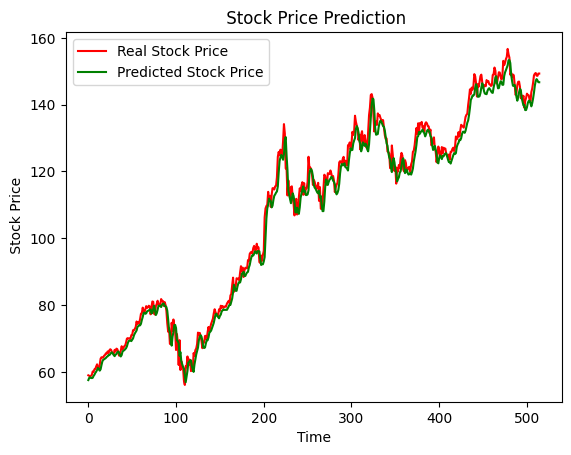

In [36]:
plt.plot(y_test, color = 'red', label = 'Real Stock Price')
plt.plot(predictions, color = 'green', label = 'Predicted Stock Price')
plt.title(' Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel(' Stock Price')
plt.legend()
plt.show()

In [37]:
models = ['Baseline', 'Linear Regression', 'Support Vector Regression', 'Random Forest Regression', 'LSTM']
mse_scores = [mse_baseline, mse_lr, mse_svr, mse_rf, mse_lstm]
rmse_scores = [rmse_baseline, rmse_lr, rmse_svr, rmse_rf, rmse_lstm]
mae_scores = [mae_baseline, mae_lr, mae_svr, mae_rf, mae_lstm]
mape_scores = [mape_baseline, mape_lr, mape_svr, mape_rf, mape_lstm]
r2_scores = [r2_baseline, r2_lr, r2_svr, r2_rf, r2_lstm]

# Create a dataframe to store the evaluation metrics
evaluation_df = pd.DataFrame({'Model': models, 'MSE': mse_scores, 'RMSE': rmse_scores, 'MAE': mae_scores, 'MAPE': mape_scores, 'R2 Score': r2_scores})
evaluation_df.set_index('Model', inplace=True)

# Print the evaluation metrics
print(evaluation_df)

                                  MSE       RMSE        MAE         MAPE  \
Model                                                                      
Baseline                   699.391785  26.446016  16.531208  3514.808664   
Linear Regression            0.049016   0.221395   0.060834     0.739091   
Support Vector Regression    0.108938   0.330057   0.137131    21.582728   
Random Forest Regression     0.110951   0.333093   0.087575     0.879974   
LSTM                         8.682059   2.946533   2.332526     2.201864   

                           R2 Score  
Model                                
Baseline                  -0.000318  
Linear Regression          0.999930  
Support Vector Regression  0.999844  
Random Forest Regression   0.999841  
LSTM                       0.989922  
